In [80]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [143]:
def cut_frame(image, max_cut=.25, default_cut=0.05):
    """
    Cuts black frame of the image. (from Martyna)
    """
    # treshold implementation
    [H, W, n] = image.shape
    ret, thresh = cv2.threshold(image, 20, 255, cv2.THRESH_BINARY_INV)
    edged = cv2.Canny(thresh, 0,50)
    contours,_ = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    contours_poly = [None] * len(contours)
    boundRect = [None] * len(contours)
    for i, c in enumerate(contours):
        contours_poly[i] = cv2.approxPolyDP(c, 3, True)
        boundRect[i] = cv2.boundingRect(contours_poly[i])
    print(boundRect)
    [x, y, w, h] = sorted(boundRect, key=lambda coef: coef[3])[-1]
    print([x, y, w, h])
    # check output points, if points are incorrect set default values
    if max_cut < 1:
        max_cut = int(H * max_cut)
    if default_cut < 1:
        default_cut = int(H * default_cut)
    if x > max_cut or y > max_cut: # to adjust
        x = y = default_cut
        w = h = H - default_cut
    if w < (H - max_cut) or h < (H - max_cut): # to adjust
        x = y = default_cut
        w = h = H - default_cut
    print(x, y, w, h)
    return x, y, w, h

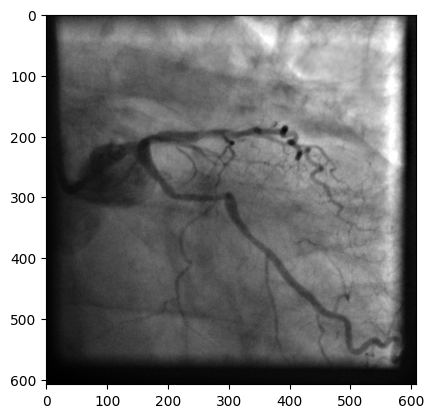

In [144]:
image_path = "./data/dataset/14_021_4_0053.bmp"
image = cv2.imread(image_path)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(image)

In [145]:
[x, y, w, h] = cut_frame(image)
[x, y, w, h]

[(477, 582, 1, 1), (522, 581, 56, 2), (479, 581, 42, 3), (428, 580, 48, 3), (319, 580, 1, 1), (478, 579, 1, 1), (201, 579, 1, 1), (466, 578, 1, 1), (218, 577, 1, 1), (205, 577, 12, 2), (197, 577, 7, 3), (222, 576, 205, 6), (155, 575, 41, 5), (134, 574, 1, 1), (121, 574, 12, 2), (137, 574, 17, 4), (107, 572, 9, 3), (89, 573, 7, 2), (74, 571, 1, 1), (579, 570, 5, 11), (116, 570, 4, 4), (97, 570, 10, 4), (76, 571, 14, 1), (81, 569, 1, 1), (578, 567, 1, 1), (55, 566, 1, 1), (581, 565, 3, 4), (53, 565, 26, 6), (50, 564, 6, 3), (48, 561, 1, 1), (583, 560, 3, 5), (34, 560, 15, 6), (32, 558, 1, 1), (36, 557, 6, 3), (46, 554, 2, 6), (25, 553, 1, 1), (41, 551, 5, 4), (39, 551, 1, 1), (27, 548, 7, 9), (27, 548, 1, 1), (38, 544, 6, 6), (33, 544, 5, 9), (586, 543, 4, 16), (24, 543, 4, 4), (27, 541, 1, 1), (28, 538, 1, 1), (588, 537, 3, 5), (22, 537, 1, 1), (24, 536, 1, 6), (589, 535, 1, 1), (587, 534, 1, 1), (22, 532, 3, 4), (588, 526, 3, 7), (589, 523, 1, 1), (589, 521, 1, 1), (586, 501, 4, 24), (

[30, 30, 578, 578]

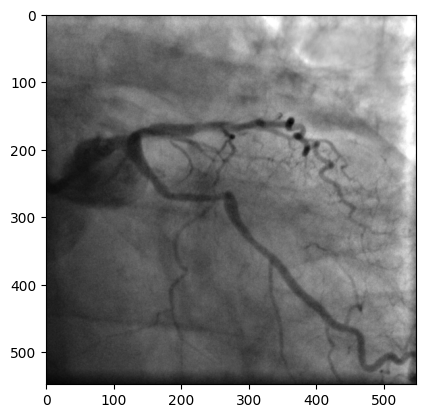

In [146]:
plt.imshow(image[x:(w), y:(h)])

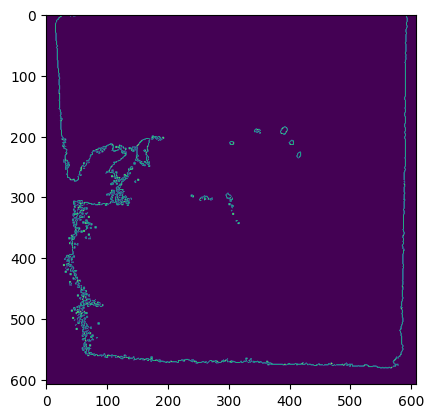

In [123]:
ret, thresh = cv2.threshold(image, 40, 255, cv2.THRESH_BINARY)
edged = cv2.Canny(thresh, 0,50)
plt.imshow(edged)

In [130]:
rho = 1  # distance resolution in pixels of the Hough grid
theta = np.pi / 180  # angular resolution in radians of the Hough grid
threshold = 15  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 100  # minimum number of pixels making up a line
max_line_gap = 10  # maximum gap in pixels between connectable line segments
line_image = np.copy(image) * 0  # creating a blank to draw lines on

lines = cv2.HoughLinesP(thresh, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)

In [131]:
line_image = image.copy() * 0
line_image = cv2.cvtColor(line_image, cv2.COLOR_GRAY2BGR)
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image, (x1,y1),(x2,y2), (255, 255, 0), 5)

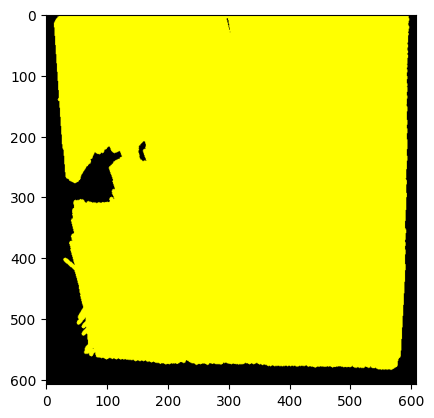

In [132]:
plt.imshow(line_image)

In [127]:
contours,_ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours

(array([[[499, 577]]], dtype=int32),
 array([[[365, 575]]], dtype=int32),
 array([[[173, 569]]], dtype=int32),
 array([[[167, 568]]], dtype=int32),
 array([[[125, 565]]], dtype=int32),
 array([[[ 69, 560]]], dtype=int32),
 array([[[ 61, 551]]], dtype=int32),
 array([[[ 60, 549]]], dtype=int32),
 array([[[ 63, 548]],
 
        [[ 63, 549]]], dtype=int32),
 array([[[ 63, 545]]], dtype=int32),
 array([[[ 63, 543]]], dtype=int32),
 array([[[ 60, 534]],
 
        [[ 61, 534]],
 
        [[ 62, 535]],
 
        [[ 62, 534]]], dtype=int32),
 array([[[ 60, 528]]], dtype=int32),
 array([[[ 50, 517]]], dtype=int32),
 array([[[ 49, 511]],
 
        [[ 50, 512]]], dtype=int32),
 array([[[ 53, 507]]], dtype=int32),
 array([[[ 58, 504]]], dtype=int32),
 array([[[ 47, 503]],
 
        [[ 48, 504]]], dtype=int32),
 array([[[ 52, 500]],
 
        [[ 52, 501]],
 
        [[ 53, 500]]], dtype=int32),
 array([[[ 44, 499]]], dtype=int32),
 array([[[ 54, 498]],
 
        [[ 55, 498]]], dtype=int32),
 array(

In [77]:
cv2.drawContours(image, contours, -1, (255,255,255), 3)

array([[11,  9, 10, ..., 21, 24, 26],
       [ 6, 10,  9, ..., 24, 25, 23],
       [ 8,  9, 10, ..., 27, 26, 26],
       ...,
       [ 0,  0,  0, ...,  5,  5,  4],
       [ 0,  0,  0, ...,  4,  4,  3],
       [ 0,  0,  0, ...,  4,  4,  5]], dtype=uint8)

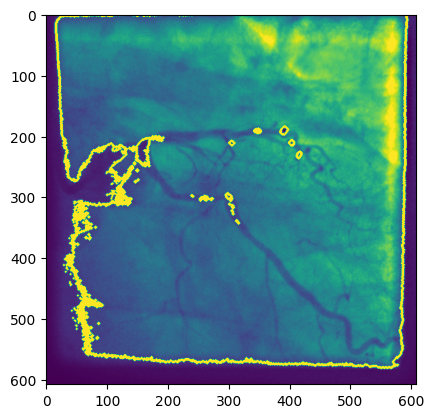

In [78]:
plt.imshow(image)

In [36]:
sorted([(15, 15, 481, 481)], key=lambda coef: coef[3])[-1]

(15, 15, 481, 481)